# 6.1 텍스트 데이터 다루기

## 6.1.1 단어와 문자의 원-핫 인코딩

In [0]:
# 단어 수준의 원-핫 인코딩하기
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']  # 초기 데이터: 각원소가 샘플

token_index = {}  # 데이터에 있는 모든 토큰의 인덱스를 구축
for sample in samples:
  for word in sample.split():   # split() 메서드를 사용하여 샘플을 토큰으로 나눔
    if word not in token_index:
      token_index[word] = len(token_index) + 1  # 단어마다 고유한 인덱스를 할당합니다. 인덱스 0은 사용하지 않는다  

max_length = 10  # 샘플을 벡터로 변환합니다. 각 샘플에서 max_length까지 단어만 사용
results = np.zeros(shape=(len(samples),
                          max_length,
                          max(token_index.values()) + 1))   # 경과를 저장할 배열
for i, sample in enumerate(samples):
  for j, word in list(enumerate(sample.split()))[:max_length]:
    index = token_index.get(word)
    results[i, j, index] = 1.

In [0]:
# 문자 수준 원-핫 인코딩하기
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable  # 출력 가능한 모든 아스키 문자
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
  for j, character in enumerate(sample):
    index = token_index.get(character)
    results[i, j, index] = 1.

In [0]:
# 캐라스를 사용한 단어 수준의 원-핫 인코딩하기
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000) # 가장 빈도가 높은 1000개의 단어만 선택하도록 Tokenizer 객체를 만듬
tokenizer.fit_on_texts(samples)  # 단어 인덱스를 구축

sequences = tokenizer.texts_to_sequences(samples)  # 문자열을 정수 인덱스의 리스트로 변환

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')  # 직접 원-핫 이진 벡터 표현을 얻을수 있음. 원-핫 인코딩 외에 다른 벡터화 방법들도 제공

word_index = tokenizer.word_index  # 계산된 단어 인덱스를 구함
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

Using TensorFlow backend.


9개의 고유한 토큰을 찾았습니다.


In [0]:
# 해싱 기법을 사용한 단어 수준의 원-핫 인코딩하기
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000 # 단어를 크기가 1000인 벡터로 저장. 1000개의 단어가 있다면 해싱 충돌이 늘어나고 인코딩의 정확도가 감소될것
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
  for j, word in list(enumerate(sample.split()))[:max_length]:
    index = abs(hash(word)) % dimensionality # 단어를 해싱하여 0과 1000사이의 랜덤한 정수 인덱스로 변환
    results[i, j, index] = 1.

## 6.1.2 단어의 임베딩 사용하기

In [0]:
# Embedding 층의 객체 생성하기
from keras.layers import Embedding

embedding_layer = Embedding(1000, 64)  # Embedding 층은 적어도 2개의 매개변수를 받음. 가능한 토큰의 개수(여기서는 1000으로 단어 인덱스 최댓값 +1)와 임베딩차원(여기서는 64)임

In [0]:
# Embedding 층에 사용할 IMDB 데이터 로드하기
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 20  # 사용할 텍스트의 길이(가장 빈번한 max_features개의 단어만 사용)

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features) # 정수 리스트로 데이터를 로드

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)  # 리스트를 (samples, maxlen) 크기의 2D 정수 텐서로 변환
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17465344/17464789 [==============================] - 1s 0us/step


In [0]:
# IMDB 데이터에 Embedding 층과 분류기 사용하기
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))  # 나중에 임베딩된 입력을 Flatten 층에서 펼치기 위해 Embedding층에 input_length를 지정. Embedding 층의 출력 크기는(samples, maxlen, 8)이 됨

model.add(Flatten())  # 3D 임베딩 텐서를 (samples, maxlen*8) 크기의 2D 텐서로 펼침

model.add(Dense(1, activation='sigmoid'))  # 분류기를 추가
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 71us/step - loss: 0.6673 - acc: 0.6252 - val_loss: 0.6140 - val_acc: 0.6996
Epoch 2/10
20000/20000 [==============================] - 1s 60us/step - loss: 0.5382 - acc: 0.7527 - val_loss: 0.5240 - val_acc: 0.7340
Epoch 3/10
20000/20000 [==============================] - 1s 60us/step - loss: 0.4601 - acc: 0.7895 - val_loss: 0.5001 - val_acc: 0.7468
Epoch 4/10
20000/20000 [==============================] - 1s 60us/step - loss: 0.4212 - acc: 0.8088 - val_loss: 0.4927 - val_acc: 0.7560
Epoch 5/10
20000/20000 [==============================] - 1s 58us/step - loss: 0.3940 - acc: 0.8235 - val_loss: 0.4925 - val_acc: 0.7536
Epoch 6/10
20000/20000 [==============================] - 1s 60us/step - loss: 0.3714 - acc: 0.8356 - val_loss: 0.4946 - val_acc: 0.7580
Epoch 7/10
20000/20000 [==============================] - 1s 62us/step - loss: 0.3507 - acc: 0.8485 - val_loss: 0.5006 - val_acc:

## 6.1.3 모든 내용을 적용하기: 원본 텍스트레서 단어 임베딩까지

In [0]:
# IMDB 원본 데이터 전처리하기
import os

imdb_dir = './datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [0]:
# IMDB 원본 데이터의 텍스트를 토큰화하기
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # 100개 단어 이후는 버립니다
training_samples = 200  # 훈련 샘플은 200개입니다
validation_samples = 10000  # 검증 샘플은 10,000개입니다
max_words = 10000  # 데이터셋에서 가장 빈도 높은 10,000개의 단어만 사용합니다

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

# 데이터를 훈련 세트와 검증 세트로 분할합니다.
# 샘플이 순서대로 있기 때문에 (부정 샘플이 모두 나온 후에 긍정 샘플이 옵니다) 
# 먼저 데이터를 섞습니다.
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


In [0]:
# GioVe 단어 임베딩 파일 파싱하기
glove_dir = './datasets/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


In [0]:
# GloVe 단어 임베딩 행렬 준비하기
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어는 모두 0이 됩니다.
            embedding_matrix[i] = embedding_vector

In [0]:
# 모델 정의하기
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [0]:
# 사전 훈련된 단어 임베딩을 Embedding 층에 로드하기
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [0]:
# 훈련과 평가하기
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s 2ms/step - loss: 1.6733 - acc: 0.5400 - val_loss: 0.6907 - val_acc: 0.5338
Epoch 2/10
200/200 [==============================] - 0s 964us/step - loss: 0.6077 - acc: 0.6700 - val_loss: 0.8459 - val_acc: 0.5060
Epoch 3/10
200/200 [==============================] - 0s 976us/step - loss: 0.4950 - acc: 0.7650 - val_loss: 0.6870 - val_acc: 0.5583
Epoch 4/10
200/200 [==============================] - 0s 990us/step - loss: 0.3349 - acc: 0.8950 - val_loss: 0.8019 - val_acc: 0.5098
Epoch 5/10
200/200 [==============================] - 0s 986us/step - loss: 0.2251 - acc: 0.9600 - val_loss: 0.7647 - val_acc: 0.5462
Epoch 6/10
200/200 [==============================] - 0s 983us/step - loss: 0.3254 - acc: 0.8150 - val_loss: 0.6875 - val_acc: 0.5835
Epoch 7/10
200/200 [==============================] - 0s 982us/step - loss: 0.1144 - acc: 0.9950 - val_loss: 1.0806 - val_acc: 0.5026
Epoch 8/10
200/2

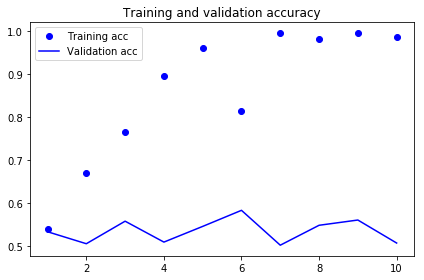

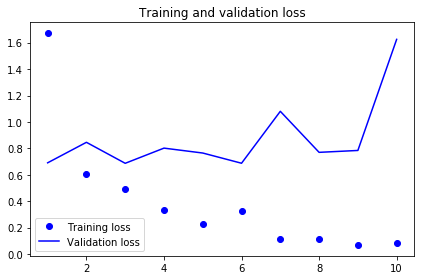

In [0]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# 사전 훈련된 단어 임베딩을 사용하지 않고 같은 모델 훈련하기
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6894 - acc: 0.5200 - val_loss: 0.6953 - val_acc: 0.5117
Epoch 2/10
200/200 [==============================] - 0s 1ms/step - loss: 0.4895 - a

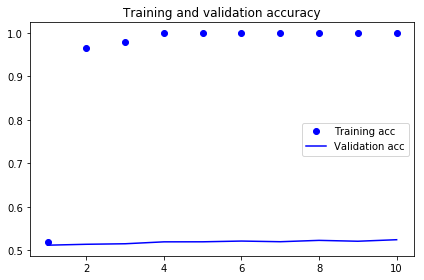

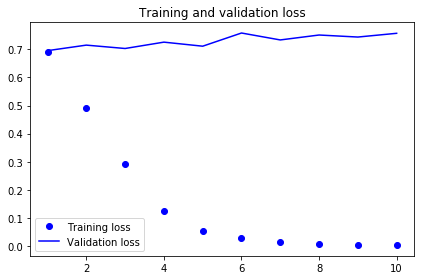

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
training_samples = 2000
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [0]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 2000 samples, validate on 10000 samples
Epoch 1/10
2000/2000 [==============================] - 0s 181us/step - loss: 0.6383 - acc: 0.6060 - val_loss: 0.6543 - val_acc: 0.6142
Epoch 2/10
2000/2000 [==============================] - 0s 177us/step - loss: 0.1578 - acc: 0.9880 - val_loss: 0.6246 - val_acc: 0.6631
Epoch 3/10
2000/2000 [==============================] - 0s 169us/step - loss: 0.0191 - acc: 0.9995 - val_loss: 0.6568 - val_acc: 0.6787
Epoch 4/10
2000/2000 [==============================] - 0s 168us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.7071 - val_acc: 0.6916
Epoch 5/10
2000/2000 [==============================] - 0s 167us/step - loss: 1.2005e-04 - acc: 1.0000 - val_loss: 0.7635 - val_acc: 0.6972
Epoch 6/10
2000/2000 [==============================] - 0s 174us/step - loss: 8.1684e-06 - acc: 1.0000 - val_loss: 0.8398 - val_acc: 0.7043
Epoch 7/10
2000/2000 [==============================] - 0s 172us/step - loss: 7.4167e-07 - acc: 1.0000 - val_loss: 0.9032 - val

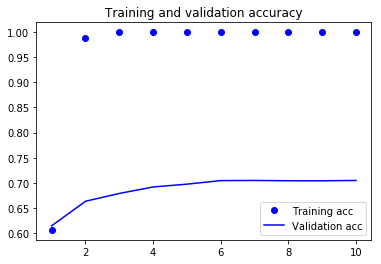

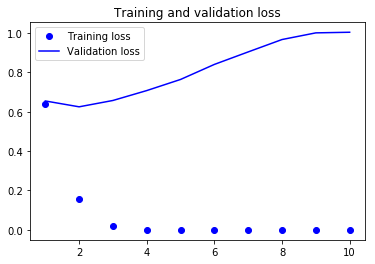

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# 테스트 데이터 토큰화하기
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [0]:
# 테스트 세트에서 모델 평가하기
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 0s 19us/step


[1.6611276818060874, 0.50412]

# 6.2 순환 신경망 이해하기

## 6.2.1 케라스의 순환 층

In [0]:
from keras.layers import SimpleRNN

Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [0]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [0]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # 맨 위 층만 마지막 출력을 반환합니다.
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


In [0]:
# IMDB 데이터 전처리하기
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

데이터 로딩...
17465344/17464789 [==============================] - 0s 0us/step
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


In [0]:
# Embedding 층과 SimpleRNN 층을 사용한 모델 훈련하기
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 27s 1ms/step - loss: 0.6532 - acc: 0.6008 - val_loss: 0.6072 - val_acc: 0.6640
Epoch 2/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.4211 - acc: 0.8246 - val_loss: 0.4305 - val_acc: 0.8146
Epoch 3/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.3005 - acc: 0.8777 - val_loss: 0.4276 - val_acc: 0.8182
Epoch 4/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.2177 - acc: 0.9168 - val_loss: 0.4024 - val_acc: 0.8386
Epoch 5/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.1606 - acc: 0.9396 - val_loss: 0.4160 - val_acc: 0.8352
Epoch 6/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.1161 - acc: 0.9607 - val_loss: 0.4943 - val_acc: 0.8248
Epoch 7/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.0607 - acc: 0.9815 - val_loss: 0.6401 - val_acc:

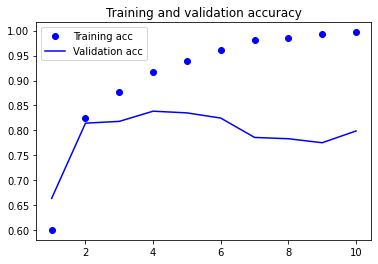

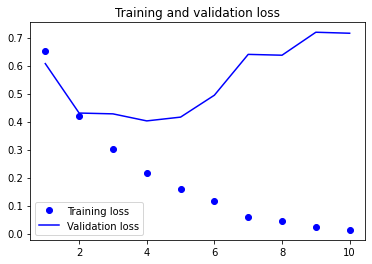

In [0]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 6.2.3 케라스를 사용한 LSTM 예제


In [0]:
# 케라스에서 LSTM 층 사용하기
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 72s 4ms/step - loss: 0.5057 - acc: 0.7625 - val_loss: 0.4757 - val_acc: 0.7618
Epoch 2/10
20000/20000 [==============================] - 70s 4ms/step - loss: 0.2928 - acc: 0.8845 - val_loss: 0.2852 - val_acc: 0.8830
Epoch 3/10
20000/20000 [==============================] - 71s 4ms/step - loss: 0.2336 - acc: 0.9095 - val_loss: 0.3046 - val_acc: 0.8722
Epoch 4/10
20000/20000 [==============================] - 71s 4ms/step - loss: 0.1961 - acc: 0.9290 - val_loss: 0.3967 - val_acc: 0.8764
Epoch 5/10
20000/20000 [==============================] - 71s 4ms/step - loss: 0.1769 - acc: 0.9355 - val_loss: 0.3084 - val_acc: 0.8858
Epoch 6/10
20000/20000 [==============================] - 72s 4ms/step - loss: 0.1504 - acc: 0.9454 - val_loss: 0.3210 - val_acc: 0.8906
Epoch 7/10
20000/20000 [==============================] - 71s 4ms/step - loss: 0.1364 - acc: 0.9518 - val_loss: 0.3083 - val_acc:

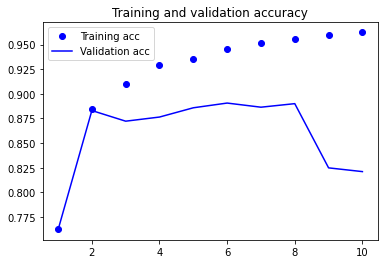

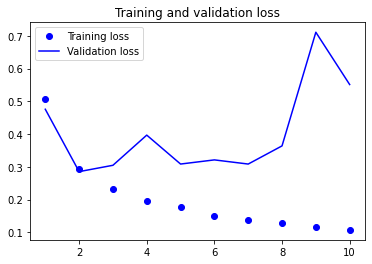

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()